<img align="left" style="padding-right:10px;" src="./images/logo_dataiku.jpg">
<p>
    **<font color='#D2691E'size="5">US Census dataset (2/2) : Final model building on the test perimeter</font>**.
</p>

<p>
    This notebook contains :
</p>
<p>
    - <b>I)</b> The automation of the preprocessing steps developped in the previous notebook ("Income_study") in a class naed "Data_Preprocessor". The preprocessing steps are applied on both train and test data. <b>Like before we avoid data leakage by fitting data scaler and pca classes with only train data</b>. It is natural to obtain different columns between test and train, even if similar transformations have been applied : Some attributes within the test categorical columns can be new or missing compared with the train ones. I make sure I have datasets talking about the same thing by the test columns on the train ones.
</p>
<p>
    - <b>II)</b> The implementation of the final classifier, a logistic regression, which is fitted with all the train data "census_income_learn.csv" in order to predict the labels of the test data "census_income_test.csv". Test performances are close to the train ones and even slightly better.
</p>

<p>
    <center>
        **<font color='	#D2691E'size="6">PLAN</font>**
    </center>
</p>
<p>
        **<font color='#D2691E'size="4">0) Libraries, functions and datasources import</font>**
</p>
<p>
        **<font color='#D2691E'size="4">I) Check of the train and test columns : integrity and similarity</font>**
</p>
<p>
        **<font color='#D2691E'size="4">II) Data preprocessing on train then test datasets</font>**
</p>
<p>
        **<font color='#D2691E'size="4">II.1) Global preprocessing</font>**
</p>
<p>
        **<font color='#D2691E'size="4">II.2) Preprocessing analysis on both perimeters</font>**
</p>
<p>
        **<font color='#D2691E'size="4">II.3) Alignment of the test perimeter on the train perimeter</font>**
</p>
<p>
        **<font color='#D2691E'size="4">II.4) Scaling and dimension reduction</font>**
</p>
<p>
        **<font color='#D2691E'size="4">III) Final model implementation</font>**
</p>

<p>
        **<font color='#D2691E'size="4">0) Libraries, functions and datasources import</font>**
</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing  import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
class Bamboos():
    import numpy as np
    
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.orig_columns = list(self.dataframe.columns)
        self.n_orig_rows = dataframe.shape[0]
        self.n_orig_cols = dataframe.shape[1]
        self.cols = list(dataframe.columns)
        self.new_cols = []
        self.deleted_cols = []
        self.n_rows = None
        self.n_cols = None
        self.step_id = 0
        self.step_label = 'init'
        
        self.possible_keys = []
        
        #self.df_datatypes = pd.DataFrame(columns = ['step_id', 'step_label', 'column', 'datatype'])
        self.cols_caracs = pd.DataFrame(columns = ['step_id', 'step_label', 'col', 'col_datatype', 'completion_ratio', 'unique_ratio'])
        
        self.orig_cols_caracs = self.get_cols_caracs()
        self.orig_incomplete_cols = self.get_incomplete_cols()
        
        self.L_metadata_labels = ['step_id', 'step_label', 'global_completion_ratio',
                                  'incomplete_cols_ratio' ,'n_rows', 'n_cols', 'cols',
                                  'n_incomplete_cols', 'incomplete_cols', 'n_new_cols',
                                  'new_cols', 'n_deleted_cols','deleted_cols']
        self.metadata_buffer = pd.DataFrame(columns=self.L_metadata_labels)
        self.metadata_buffer = self.update_metadata_buffer(dataframe)
        
        
    def get_cols_caracs(self, arg='last'):
        dict_col_caracs = {}
        dataframe_length = len(self.dataframe)
        
        if len(self.dataframe)>0:
            for col in self.dataframe.columns:
                dict_col_caracs[col] = {}
                col_datatype = str(self.dataframe[col].dtype)
                dict_col_caracs[col]['step_id'] = self.step_id
                dict_col_caracs[col]['step_label'] = self.step_label
                dict_col_caracs[col]['col'] = col
                dict_col_caracs[col]['col_datatype'] = col_datatype
                                
                completion_ratio = len(self.dataframe[col][~self.dataframe[col].isnull()])/dataframe_length
                unique_ratio = len(np.unique(list(self.dataframe[col])))/dataframe_length
                dict_col_caracs[col]['completion_ratio'] = completion_ratio
                dict_col_caracs[col]['unique_ratio'] = unique_ratio
                dict_col_caracs[col]['step_label'] = self.step_label
                if unique_ratio == 1.0:
                    self.possible_keys.append(col)
            
            self.cols_caracs = self.cols_caracs.append(pd.DataFrame(dict_col_caracs).T)
            self.cols_caracs.drop_duplicates(subset=['step_id', 'col'], inplace=True)
            self.cols_caracs = self.cols_caracs[['step_id', 'step_label', 'col_datatype', 'completion_ratio', 'unique_ratio']]
            if arg == 'last':
                last_cols_caracs = self.cols_caracs[self.cols_caracs['step_id']==np.max(self.cols_caracs['step_id'])]
                return last_cols_caracs
            else:
                return self.cols_caracs
        else:
            return 'empty df !'
    
    def get_incomplete_cols(self):
        df_incomplete_cols = self.cols_caracs[(self.cols_caracs['completion_ratio']<1.0)&(self.cols_caracs['step_label']==self.step_label)]        
        df_incomplete_cols.sort_values(by='completion_ratio', ascending=False, inplace=True)
        self.incomplete_cols = list(df_incomplete_cols.index)
        self.n_incomplete_cols = len(self.incomplete_cols)
        return self.incomplete_cols
    
    def flag_one_step(self, flag_label, dataframe):
        print("flagging : %s"%flag_label)
        self.step_id+=1
        self.step_label = flag_label
        #self.get_cols_caracs()
        self.update_metadata_buffer(dataframe)
    
    def update_metadata_buffer(self, dataframe):
        self.new_cols = [col for col in dataframe.columns if not col in self.cols]
        self.n_new_cols = len(self.new_cols)
        self.deleted_cols = [col for col in self.cols if not col in dataframe.columns]
        self.n_deleted_cols = len(self.deleted_cols)
        self.dataframe = dataframe
        self.get_cols_caracs()
        self.get_incomplete_cols()
        self.cols = list(self.dataframe.columns)
        self.n_rows = dataframe.shape[0]
        self.n_cols = dataframe.shape[1]
        self.global_completion_ratio = np.sum(self.cols_caracs['completion_ratio'])/len(self.cols_caracs['completion_ratio'])
        self.incomplete_cols_ratio = len(set(self.incomplete_cols).intersection(set(self.cols)))/len(self.cols)
        self.L_metadata_values = [self.step_id, self.step_label, self.global_completion_ratio,
                                  self.incomplete_cols_ratio, self.n_rows, self.n_cols, self.cols,
                                  self.n_incomplete_cols, self.incomplete_cols, self.n_new_cols, 
                                  self.new_cols, self.n_deleted_cols, self.deleted_cols]
        dict_metadata_buffer = {label:value for label,value in zip(self.L_metadata_labels, self.L_metadata_values)}
        self.metadata_buffer = self.metadata_buffer.append(dict_metadata_buffer, ignore_index=True)
        
        cols_with_list_type = ['cols', 'incomplete_cols', 'new_cols', 'deleted_cols']
        for col in cols_with_list_type:
            self.metadata_buffer[col] = self.metadata_buffer[col].astype(str)
            
        self.metadata_buffer.drop_duplicates(inplace=True)
        self.metadata_buffer.sort_values(by='step_id', ascending=False, inplace=True)
        
        for col in cols_with_list_type:
            self.metadata_buffer = self.convert_in_list(self.metadata_buffer, col)
        return self.metadata_buffer
    
    def get_metadata_buffer(self):
        return self.metadata_buffer
    
    
    def get_steps(self):
        if len(self.dataframe)>0 :
            return self.cols_caracs[['step_id', 'step_label']].drop_duplicates()
        else:
            return 'empty df !'
    

    def sorted_columns(self, reverse = False):
        sorted_cols = sorted(list(self.dataframe.columns), reverse=reverse)
        return sorted_cols
    
    def sorted_columns_from_keys(self, list_of_keys):
        sorted_cols = list_of_keys
        for col in self.dataframe.columns:
            if not col in sorted_cols:
                sorted_cols.append(col)
        return sorted_cols
    
    def convert_in_list(self, dataframe, col):
        from ast import literal_eval
        """
        This function goal is to convert a pandas column into a "list" datatype column
        IMPORTANT : The column values must match with the python lists pattern in order to be read and converted correctly.

        RESULT : The same column, with each value converted into an array : that's also possible to loop over the array values

        PARAMS :
        - dataframe : the entry DataFrame
        - col : String, the column to convert
        """
        dataframe[col] = dataframe[col].apply(literal_eval)
        return dataframe

In [3]:
df_metadatas = pd.read_csv('columns_metadatas.csv', sep=';')
L_data_schema = list(df_metadatas['column_name'])
df_metadatas.head(10)

,column_name,datatype
0,age,continuous
1,class_of_worker,nominal
2,detailed_industry_recode,nominal
3,detailed_occupation_recode,nominal
4,education,nominal
5,wage_per_hour,continuous
6,enroll_in_edu_inst_last_wk,nominal
7,marital_stat,nominal
8,major_industry_code,nominal
9,major_occupation_code,nominal


In [4]:
#There is a problem within the test data format : some columns are unnamed and worse, other are shifted : 
#So we have to map some columns to their correct names. To do this we use this dict :

df_test = pd.read_csv('census_income_test.csv', sep=';')
dict_test_rename = {'migration_code-change_in_msa':'ignore',
                    'migration_code-change_in_reg':'migration_code-change_in_msa',
                    'migration_code-move_within_reg':'migration_code-change_in_reg',
                    'live_in_this_house_1_year_ago':'migration_code-move_within_reg',
                    'migration_prev_res_in_sunbelt':'live_in_this_house_1_year_ago',
                    'Unnamed: 29':'migration_prev_res_in_sunbelt',
                    'Unnamed: 41':'income_level'}

df_test.rename(dict_test_rename, axis=1, inplace=True)
df_test.drop('ignore', axis=1, inplace=True)

In [5]:
df_train = pd.read_csv('census_income_learn.csv', sep=',', names=L_data_schema)
df_train.drop('ignore', axis=1, inplace=True)

<p>
        **<font color='#D2691E'size="4">I) Check of the train and test columns : integrity and similarity</font>**
</p>

In [6]:
#We now have to check if both dataframes have the same schema : 
check_1 = [col for col in df_train.columns if not col in df_test.columns]
check_2 = [col for col in df_test.columns if not col in df_train.columns]
print("columns of the train perimeter absent from the test perimeter : %s"%check_1)
print("columns of the test perimeter absent from the train perimeter : %s"%check_2)

columns of the train perimeter absent from the test perimeter : []
columns of the test perimeter absent from the train perimeter : []


<p>
        **<font color='#D2691E'size="4">II) Data preprocessing on train then test datasets</font>**
</p>

<p>
        **<font color='#D2691E'size="4">II.1) Global preprocessing</font>**
</p>

In [7]:
class Data_Preprocessor:

    def __init__(self):
        self.df_metadatas = pd.read_csv('columns_metadatas.csv', sep=';')
        self.df_metadatas = self.df_metadatas[self.df_metadatas['column_name']!='ignore']
        self.L_cols_to_drop = ['detailed_industry_recode', 'hispanic_origin', 'state_of_previous_residence',
                               'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self']
        self.dict_metadata_buffer = {'train':None,'test':None}
        self.dict_bamboos = {'train':None,'test':None}

    def preprocess(self, dataframe, perimeter):
        """
        This function goal is to reproduce all the preprocessiong steps done in the 
        notebook "Income_study". 
        All steps are saved, thanks to a "Bamboos" class, in :
                - 'self.dict_metadata_buffer' : A dictionary attribute of the "Data_Preprocessor" class which 
                directly contains metadatas of the dataset during the different steps 
                (number of rows/columns, added columns, dataset completion ratio, etc...).
                
                - 'self.dict_bamboos' : A dictionary attribute of the "Data_Preprocessor" class which contains
                other attributes of the "Bamboos" class than the "metadata buffer".
                
                This two dictionaries has two keys, 'train' and 'test', to access 
                to the data of their respective perimeters
        
        RESULT : Preprocessed dataframes
        
        PARAMS : 
        - 'dataframe' : the pandas DataFrame to preprocess
        - 'perimeter' : a string which precise if the transforms concerns train or test perimeters.
                        this parameter is important since it allows to save the preprocessing steps metadatas
                        in "self.dict_metadata_buffer" and  "self.dict_bamboos".
        
        """
        print("Preprocessing on the %s perimeter ..."%perimeter)
        bamboos = Bamboos(dataframe)
        cols_caracs = bamboos.get_cols_caracs()
        
        L_continuous_cols = list(self.df_metadatas['column_name'][self.df_metadatas['datatype']=='continuous'])
        for col in L_continuous_cols :
            dataframe[col] = dataframe[col].astype(float)
        
        L_categorical_cols = list(self.df_metadatas['column_name'][self.df_metadatas['datatype']=='nominal'])
        L_categorical_cols.remove('income_level')
        for col in L_categorical_cols : 
            dataframe[col] = dataframe[col].astype(str)
        
        bamboos.flag_one_step('affecting_correct_datatypes', dataframe)
        
        #Categorical columns vectorization
        dataframe.drop(self.L_cols_to_drop, axis=1, inplace=True)
        for col in self.L_cols_to_drop:
            L_categorical_cols.remove(col)
        
        start_time = time.time()
        for col in L_categorical_cols:
            dataframe[col] = dataframe[col].str.lower()
            dataframe[col] = dataframe[col].str.replace('^ ','')
            dataframe[col] = dataframe[col].str.replace(' ','_')
            dataframe = pd.merge(dataframe, pd.get_dummies(dataframe[col], prefix=col), how='left', left_index=True, right_index=True)
        print("--- %s seconds to vectorize the categorical columns ---" % (time.time() - start_time))
        dataframe.drop(L_categorical_cols, axis=1, inplace=True)
        bamboos.flag_one_step('categorical_columns_vectorization', dataframe)
        metadata_buffer = bamboos.metadata_buffer
        print("Categorical columns vectorization appended %s new columns !"%list(metadata_buffer['n_new_cols'])[0])
        self.dict_metadata_buffer[perimeter] = metadata_buffer
        self.dict_bamboos[perimeter] = bamboos
        
        if perimeter=='train':
            self.final_schema = list(dataframe.columns)
            self.L_predictors = [col for col in dataframe.columns if col!='income_level']
        
        return dataframe

    def align_on_train_schema(self, dataframe):
        """
        This function goal is to align the ultimate test dataframe schema 
        with the schema of the ultimate train daframe.
        Categorical columns which where in the train perimeter but which are absent from this one 
        have their values filled with "0"
        
        RESULT : A pandas dataframe which have exactly the same schema as the ultimate train dataframe
        
        PARAMS : 
        - 'dataframe' : a pandas DataFrame object resulting from  the function "preprocess".
        """
        print("\n\nDataframes alignment ...")
        #First we create an empty DataFrame which have the final train schema :
        df_aligned = pd.DataFrame(columns=self.final_schema)
        #Then we use "pd.concat" in order to align all the test values with the train schema:
        df_aligned = pd.concat([df_aligned, dataframe])
        #Finally we restrict the DataFrame columns on the final schema : 
        df_aligned = df_aligned[self.final_schema]
        
        #Some (vectorized categorical) columns of the train perimeter can be absent in the test perimeter : 
        L_cols_in_train_not_in_test = [col for col in self.final_schema if not col in dataframe.columns]
        #If one of this columns is absent we replace its values by "0", since their attributes really did'nt existed 
        for col in L_cols_in_train_not_in_test:
            df_aligned[col] = 0
        bamboos = self.dict_bamboos['test']
        bamboos.flag_one_step('columns_alignment_on_train_perimeter', df_aligned)
        self.dict_bamboos['test']  = bamboos
        
        return df_aligned
    
    def split_in_predictors_and_target(self, dataframe, perimeter):
        """
        This function goal is to return predictors and target from a given dataframe.
        
        RESULT : 
        - X : A 2D array of predictors
        - y : A 1D array which represents the predictors target
        
        PARAMS : 
        - 'dataframe' : a pandas DataFrame object which contains all the data (predictors+target)
        - 'perimeter' : a string which precise if the transforms concerns train or test perimeters. 
                        this parameter is important since it allows to instanciate the "Data_Preprocessor"
                        attribute "self.label_encoder" thanks to the function "encode_label" (see below).
        """
        X = dataframe[self.L_predictors].values
        y = dataframe['income_level'].values
        y = self.encode_label(y, perimeter)
           
        return X, y
    
    def encode_label(self, labels, perimeter):
        """
        This function goal is to encode categorical labels with a label encoder
        The label encoder is first instanciated and fitted with the train data.
        It is then saved as an attribute (self.label_encoder) in the "Data_Preprocessor" instance 
        When the label encoder is fitted, it can be used to encode both 
        train and test data.
        
        RESULT : A 1D array of encoded labels

        PARAMS :
        - 'labels' : The raw 1D array of labels
        - 'perimeter' : a string which precise if the transforms concerns train or test perimeters
        """
        if perimeter=='train':
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(labels)
        
        encoded_labels = self.label_encoder.transform(labels)
        
        return encoded_labels
        
    
    def scale(self, data, perimeter):
        """
        This function goal is to scale the data with a standard scaler
        The data scaler is first instanciated and fitted with the train data.
        It is then saved as an attribute (self.data_scaler) in the "Data_Preprocessor" instance 
        When the data scaler is fitted, it can be used to scale both 
        train and test data.
        This way allows to avoid data leakage in the scaling step
        
        RESULT : A numpy 2D array of data scaled with a standard scaler

        PARAMS :
        - 'data' : The raw 2D array of data
        - 'perimeter' : a string which precise if the transforms concerns train or test perimeters
        """
        print("\n\nScaling the data |perimeter = %s ..."%perimeter)
        if perimeter == 'train':
            self.data_scaler = preprocessing.StandardScaler().fit(data)
        X_scaled = self.data_scaler.transform(data)
        
        return X_scaled

    def reduce_dim(self, data, perimeter):
        """
        This function goal is to reduce the dimension of scaled data with a PCA
        The PCA is first instanciated and fitted with the train data.
        It is then saved as an attribute (self.pca) in the "Data_Preprocessor" instance 
        When the PCA is fitted, it can be used to scale both 
        train and test data.
        This way allows to avoid data leakage in the dimension reduction step
        
        RESULT : A numpy 2D array of data with a dim "dim_out" such as dim_out==150 < dim_in

        PARAMS :
        - 'data' : The raw 2D array of scaled data
        - 'perimeter' : a string which precise if the transforms concerns train or test perimeters
        """
        print("\n\nReducing the data dimension | perimeter = %s ..."%perimeter)
        if perimeter == 'train':
            self.pca = PCA(n_components=150)
            self.pca.fit(data)
            print('pca explained variance ratio : %s'%self.pca.explained_variance_ratio_.sum())
        X_PCA = self.pca.transform(data)
        
        return X_PCA

In [8]:
data_preprocessor = Data_Preprocessor()
df_train = data_preprocessor.preprocess(df_train, 'train')
df_test = data_preprocessor.preprocess(df_test, 'test')
#We can see that we have one less column vectorized in the test dataframe, after its preprocessing

Preprocessing on the train perimeter ...


c:\python\python36\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


flagging : affecting_correct_datatypes
--- 13.032292127609253 seconds to vectorize the categorical columns ---
flagging : categorical_columns_vectorization
Categorical columns vectorization appended 261 new columns !
Preprocessing on the test perimeter ...
flagging : affecting_correct_datatypes
--- 6.080799102783203 seconds to vectorize the categorical columns ---
flagging : categorical_columns_vectorization
Categorical columns vectorization appended 260 new columns !


<p>
        **<font color='#D2691E'size="4">II.2) Preprocessing Analysis on both perimeters</font>**
</p>

In [9]:
data_preprocessor.dict_metadata_buffer['train']

,step_id,step_label,global_completion_ratio,incomplete_cols_ratio,n_rows,n_cols,cols,n_incomplete_cols,incomplete_cols,n_new_cols,new_cols,n_deleted_cols,deleted_cols
2,2,categorical_columns_vectorization,1.0,0.0,199523,269,"[age, wage_per_hour, capital_gains, capital_lo...",0,[],261,"[class_of_worker_federal_government, class_of_...",33,"[class_of_worker, detailed_industry_recode, de..."
0,1,affecting_correct_datatypes,1.0,0.0,199523,41,"[age, class_of_worker, detailed_industry_recod...",0,[],0,[],0,[]
1,0,init,1.0,0.0,199523,41,"[age, class_of_worker, detailed_industry_recod...",0,[],0,[],0,[]


In [10]:
data_preprocessor.dict_metadata_buffer['test']

,step_id,step_label,global_completion_ratio,incomplete_cols_ratio,n_rows,n_cols,cols,n_incomplete_cols,incomplete_cols,n_new_cols,new_cols,n_deleted_cols,deleted_cols
2,2,categorical_columns_vectorization,1.0,0.0,99762,268,"[age, wage_per_hour, capital_gains, capital_lo...",0,[],260,"[class_of_worker_federal_government, class_of_...",33,"[class_of_worker, detailed_industry_recode, de..."
0,1,affecting_correct_datatypes,1.0,0.0,99762,41,"[age, class_of_worker, detailed_industry_recod...",0,[],0,[],0,[]
1,0,init,1.0,0.0,99762,41,"[age, class_of_worker, detailed_industry_recod...",0,[],0,[],0,[]


In [11]:
#Columns that are in the train DataFrame but absent in the test one : 
L_cols_in_train_not_in_test = [col for col in df_train.columns if not col in df_test.columns]
L_cols_in_train_not_in_test

['detailed_household_and_family_stat_grandchild_<18_ever_marr_not_in_subfamily']

In [12]:
#Columns that are in the test DataFrame but absent in the train one : 
L_cols_in_test_not_in_train = [col for col in df_test.columns if not col in df_train.columns]
L_cols_in_test_not_in_train

[]

<p>
        **<font color='#D2691E'size="4">II.3) Alignment of the test perimeter on the train perimeter</font>**
</p>

In [13]:
#We have to be sure that both test and train have the same schemas 
##=> So we align the test schema on the train one : 
df_test = data_preprocessor.align_on_train_schema(df_test)



Dataframes alignment ...
flagging : columns_alignment_on_train_perimeter


c:\python\python36\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
data_preprocessor.dict_bamboos['test'].metadata_buffer
#Now both dataframes have the same "269" columns in their final schemas

,step_id,step_label,global_completion_ratio,incomplete_cols_ratio,n_rows,n_cols,cols,n_incomplete_cols,incomplete_cols,n_new_cols,new_cols,n_deleted_cols,deleted_cols
3,3,columns_alignment_on_train_perimeter,1.0,0.0,99762,269,"[age, wage_per_hour, capital_gains, capital_lo...",0,[],1,[detailed_household_and_family_stat_grandchild...,0,[]
0,2,categorical_columns_vectorization,1.0,0.0,99762,268,"[age, wage_per_hour, capital_gains, capital_lo...",0,[],260,"[class_of_worker_federal_government, class_of_...",33,"[class_of_worker, detailed_industry_recode, de..."
1,1,affecting_correct_datatypes,1.0,0.0,99762,41,"[age, class_of_worker, detailed_industry_recod...",0,[],0,[],0,[]
2,0,init,1.0,0.0,99762,41,"[age, class_of_worker, detailed_industry_recod...",0,[],0,[],0,[]


<p>
        **<font color='#D2691E'size="4">II.4) Scaling and dimension reduction</font>**
</p>

In [15]:
X_train, y_train = data_preprocessor.split_in_predictors_and_target(df_train, 'train')
X_scaled_train = data_preprocessor.scale(X_train, 'train')
X_PCA_train = data_preprocessor.reduce_dim(X_scaled_train, 'train')



Scaling the data |perimeter = train ...


Reducing the data dimension | perimeter = train ...
pca explained variance ratio : 0.9150402827118868


In [16]:
X_test, y_test = data_preprocessor.split_in_predictors_and_target(df_test, 'test')
X_scaled_test = data_preprocessor.scale(X_test, 'test')
X_PCA_test = data_preprocessor.reduce_dim(X_scaled_test, 'test')



Scaling the data |perimeter = test ...


Reducing the data dimension | perimeter = test ...


c:\python\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


<p>
        **<font color='#D2691E'size="4">III) Final model implementation</font>**
</p>

In [ ]:
#What were the results of our past logistic regression cross-validation ? 

<img align="left" style="padding-right:10px;" src="./images/log_regr_crossval_results.jpg">

In [ ]:
#=> Results seems to be the same for each couple of parameters
#=> I chose to implement the logistic regression with C = 0.1 (which implies a stronger regularization) and using the "l1" norm in
## order to have a sparser model.

In [17]:
start_time = time.time()
lr_fin = LogisticRegression(penalty='l1', C=0.1)
lr_fin.fit(X_train, y_train)
print("--- %s seconds to fit the lr model---" % (time.time() - start_time))

--- 52.02353358268738 seconds to fit the lr model---


In [18]:
#Predictions : 
y_pred_lr_fin  = lr_fin.predict(X_test)
accuracy_lr_fin = metrics.accuracy_score(y_test, y_pred_lr_fin)
print("Final accuracy on the test perimeter is : %s"%accuracy_lr_fin)

Final accuracy on the test perimeter is : 0.9535795192558288


In [19]:
df_accuracy = pd.DataFrame(y_test, columns=['y_test'])
df_accuracy['y_pred_lr_fin'] = y_pred_lr_fin
df_accuracy['lr_acc'] = 0
df_accuracy['lr_acc'][df_accuracy['y_test']==df_accuracy['y_pred_lr_fin']] = 1
df_accuracy.head()

,y_test,y_pred_lr_fin,lr_acc
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


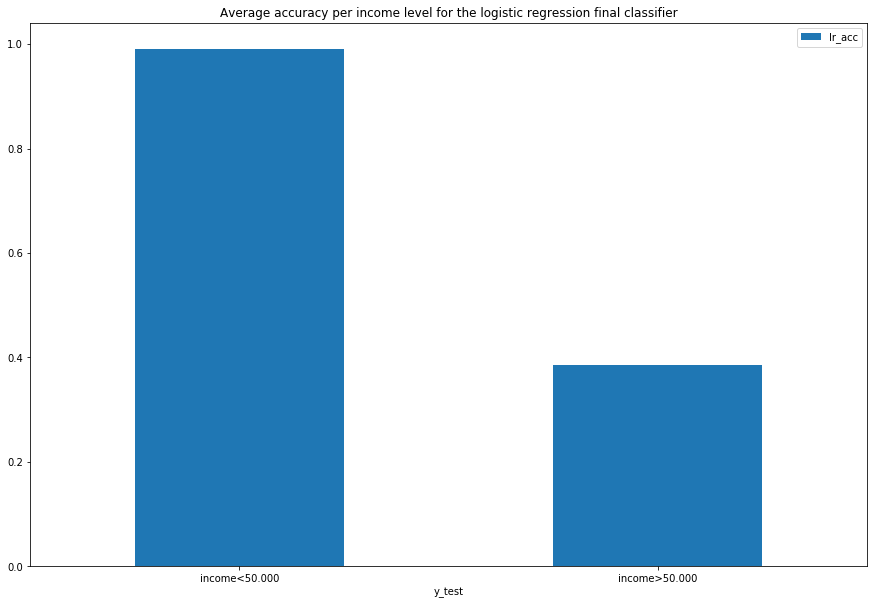

In [20]:
df_accuracy['y_test'] = df_accuracy['y_test'].astype(str)
df_accuracy['y_test'] = df_accuracy['y_test'].str.replace('0','income<50.000')
df_accuracy['y_test'] = df_accuracy['y_test'].str.replace('1','income>50.000')
grouped = df_accuracy[['y_test', 'lr_acc']].groupby('y_test').mean()
title = "Average accuracy per income level for the logistic regression final classifier"
grouped.plot.bar(figsize=(15,10), title=title, rot=0)
plt.show()

In [21]:
grouped

,lr_acc
y_test,
income<50.000,0.991141
income>50.000,0.385386


<p>
    Performances are close and slightly better than those of the previous study : <b>A global accuracy of 95.3%</b> and we are <b>4.2% more precise</b> on the higher income category, which is not negligible. 
</p>

<p>
    We could explained that by the fact that we fitted our model with 25% more data, what allowed it to better capture the relevant informations within the data.
</p>

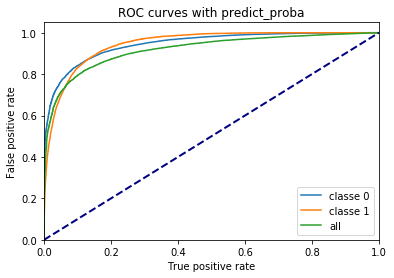

In [22]:
#Code readjusted from : http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/antiseches/ml_basic/plot_roc.html#predict-proba-ou-decision-function
fpr_cl = dict()
tpr_cl = dict()

y_pred = lr_fin.predict(X_test)
y_proba = lr_fin.predict_proba(X_test)

fpr_cl["classe 0"], tpr_cl["classe 0"], _ = roc_curve(
    y_test == 0, y_proba[:, 0].ravel())
fpr_cl["classe 1"], tpr_cl["classe 1"], _ = roc_curve(
    y_test, y_proba[:, 1].ravel())  

prob_pred = np.array([y_proba[i, 1 if c else 0]
                         for i, c in enumerate(y_pred)])
fpr_cl["all"], tpr_cl["all"], _ = roc_curve(
    (y_pred == y_test).ravel(), prob_pred)

plt.figure()
for key in fpr_cl:
    plt.plot(fpr_cl[key], tpr_cl[key], label=key)

lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title('ROC curves with predict_proba')
plt.legend(loc="lower right")
plt.show()